# Caso: Modelo de Predicción de Venta de Seguros a Clientes

Puede descargar los datos de: https://www.kaggle.com/competitions/playground-series-s4e7/data

## Instalar las librerías

In [4]:
!pip install catboost
!pip install ydata-profiling
!pip install kds
!pip install lightgbm
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 8.9 MB/s eta 0:00:00:00:0100:01


## 1. Carga de Módulos

In [139]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from ydata_profiling import ProfileReport

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, classification_report, roc_auc_score, f1_score, auc, roc_curve
)
import kds
from catboost import CatBoostClassifier, Pool

## 2. Lectura Inicial de base de datos

### 2.1 Carga de datos

In [8]:
# Leemos la data de desarrollo de modelos
df = pd.read_csv('../data/raw/insurances.csv')

In [9]:
# Vemos la dimensionalidad
df.shape

(1000000, 12)

In [10]:
# Visualizacion Global de los datos
df.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0  10300113    Male   63                1         50.0                   0   
1  10136243  Female   37                1         28.0                   0   
2   5750113    Male   44                1         28.0                   1   
3   1108035  Female   22                1          8.0                   1   
4  10706279    Male   27                1         28.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes          2630.0                 157.0       67   
1    1-2 Year            Yes         43829.0                 124.0      128   
2    1-2 Year             No         26674.0                  26.0      219   
3    < 1 Year             No         44905.0                 152.0      191   
4    < 1 Year             No          2630.0                  26.0      158   

   Response  
0         0  
1         1  
2         0  
3         0  
4         0

### 2.2. Buenas prácticas

In [11]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1000000 non-null  int64  
 1   Gender                1000000 non-null  object 
 2   Age                   1000000 non-null  int64  
 3   Driving_License       1000000 non-null  int64  
 4   Region_Code           1000000 non-null  float64
 5   Previously_Insured    1000000 non-null  int64  
 6   Vehicle_Age           1000000 non-null  object 
 7   Vehicle_Damage        1000000 non-null  object 
 8   Annual_Premium        1000000 non-null  float64
 9   Policy_Sales_Channel  1000000 non-null  float64
 10  Vintage               1000000 non-null  int64  
 11  Response              1000000 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 91.6+ MB


# 3. AED

## 3.1. Completitud de los datos

In [13]:
# Revisamos los valores nulos o missings
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## 3.2. Análisis Univariado

In [14]:
profile = ProfileReport(df, title="Reporte Pandas Profiling")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.98it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# Eliminamos columna Id
df = df.drop(columns=['id'])

In [16]:
# Verificamos duplicados
df.duplicated().sum()

0

In [17]:
## Para variables Cualitativas
def plot_cat(feature):
  sns.countplot(data=df, x=feature)
  ax=sns.countplot(data=df, x=feature, palette='tab10')

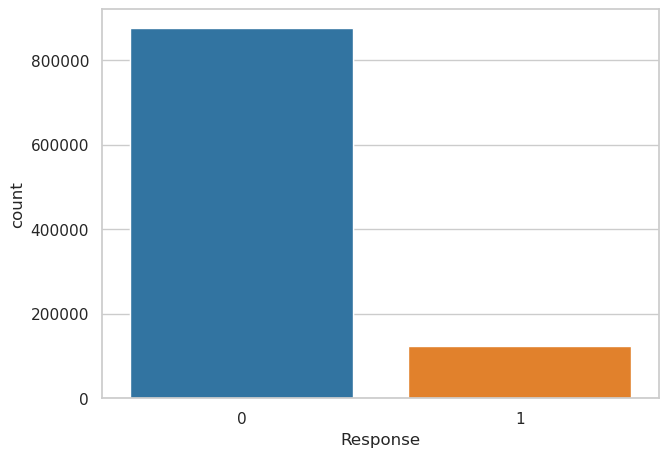

In [18]:
plot_cat('Response')

In [19]:
## Calculando la proporción del Target
df.Response.value_counts(normalize=True)

Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

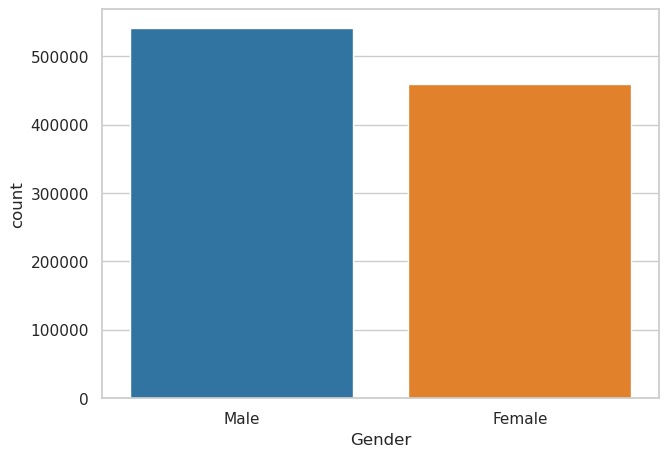

In [20]:
plot_cat('Gender')

In [21]:
df.groupby('Gender').Response.value_counts(normalize=True).unstack(fill_value=0)

Response         0         1
Gender                      
Female    0.896861  0.103139
Male      0.860166  0.139834

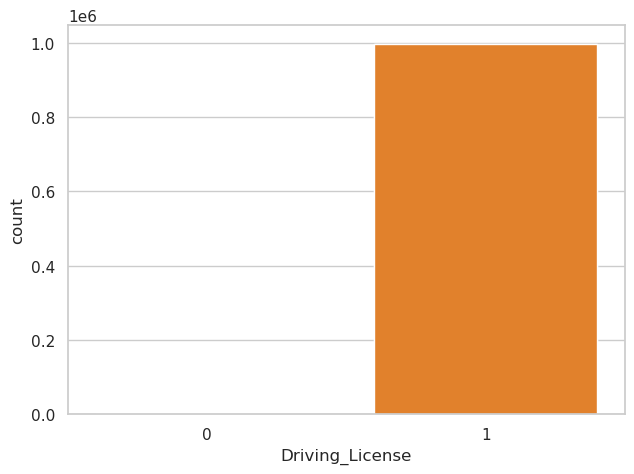

In [22]:
plot_cat('Driving_License')

In [23]:
df.groupby('Driving_License').Response.value_counts(normalize=True).unstack(fill_value=0)

Response                0         1
Driving_License                    
0                0.952811  0.047189
1                0.876852  0.123148

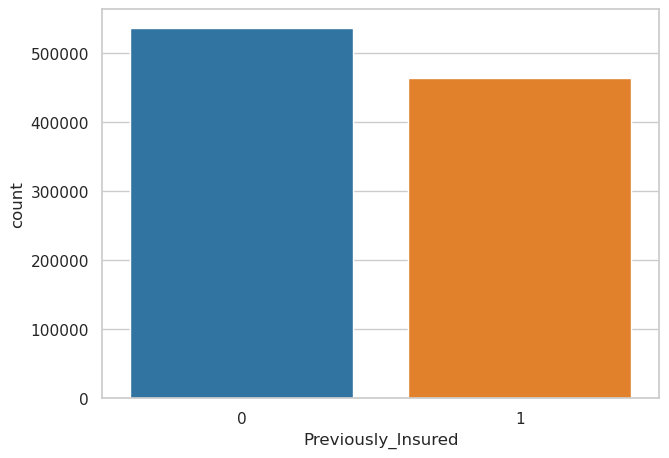

In [24]:
plot_cat('Previously_Insured')

In [25]:
df.groupby('Previously_Insured').Response.value_counts(normalize=True).unstack(fill_value=0)

Response                   0         1
Previously_Insured                    
0                   0.771392  0.228608
1                   0.999292  0.000708

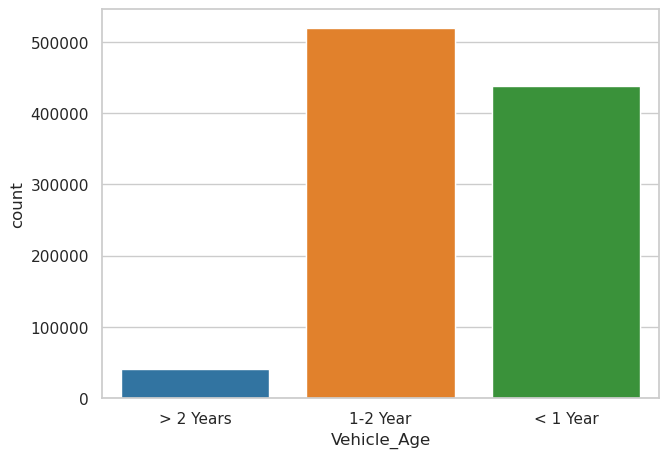

In [26]:
plot_cat('Vehicle_Age')

In [27]:
df.groupby('Vehicle_Age').Response.value_counts(normalize=True).unstack(fill_value=0)

Response            0         1
Vehicle_Age                    
1-2 Year     0.822400  0.177600
< 1 Year     0.958435  0.041565
> 2 Years    0.699393  0.300607

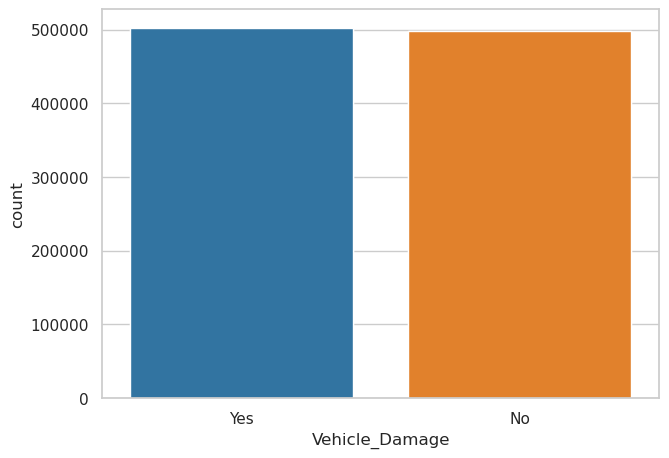

In [28]:
plot_cat('Vehicle_Damage')

In [29]:
df.groupby('Vehicle_Damage').Response.value_counts(normalize=True).unstack(fill_value=0)

Response               0         1
Vehicle_Damage                    
No              0.995855  0.004145
Yes             0.759346  0.240654

In [30]:
## Para variables cuantitativas
def plot_num(feature):
    fig,axes=plt.subplots(1,2)
    sns.boxplot(data=df,x=feature,ax=axes[0])
    sns.distplot(a=df[feature],ax=axes[1],color='#ff4125')
    fig.set_size_inches(15,5)

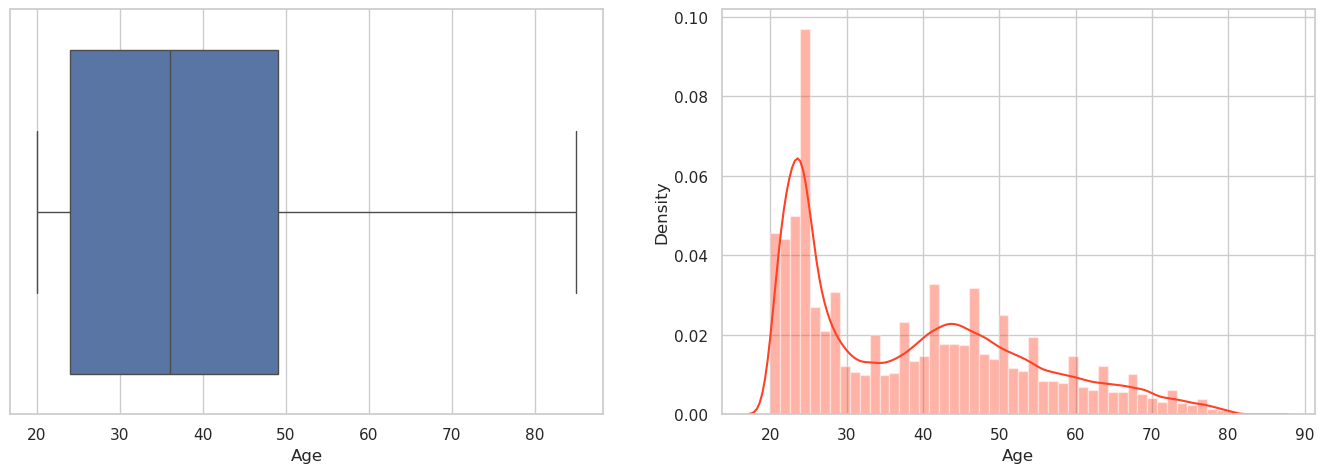

In [31]:
plot_num('Age')

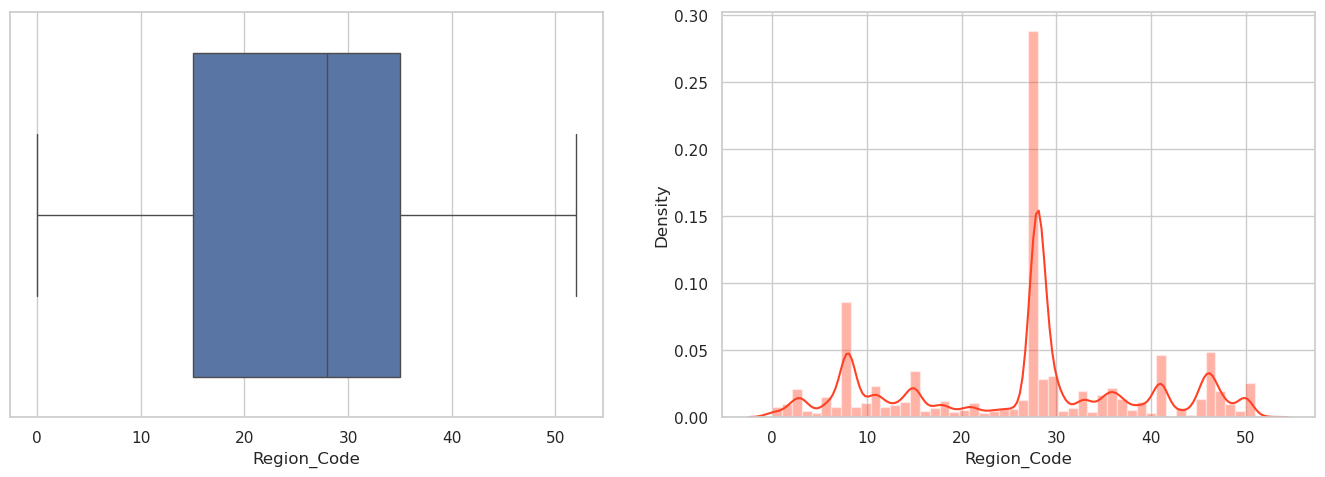

In [32]:
plot_num('Region_Code')

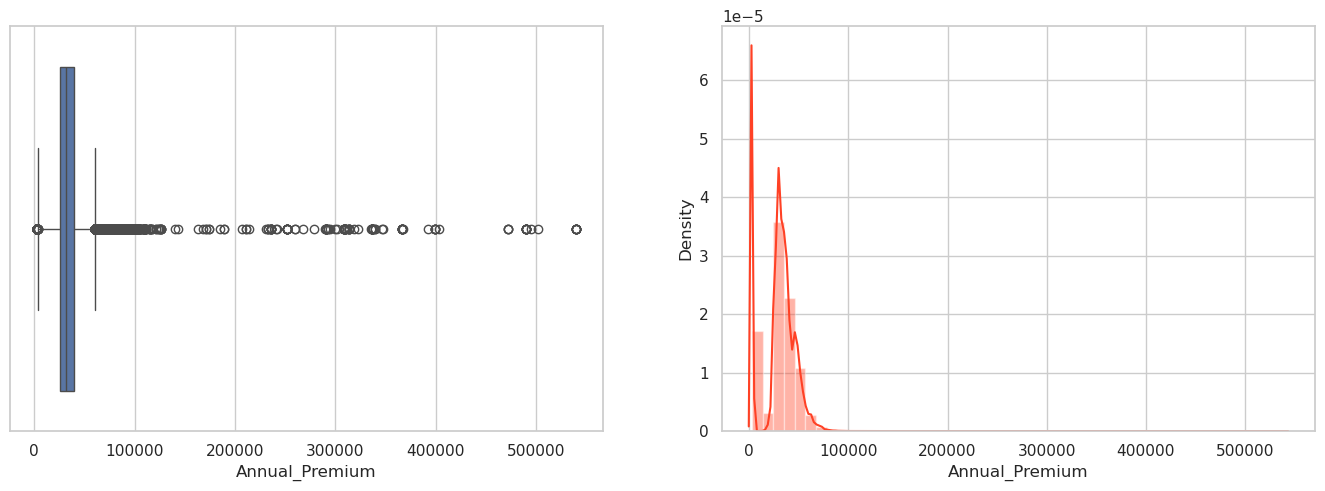

In [33]:
plot_num('Annual_Premium')

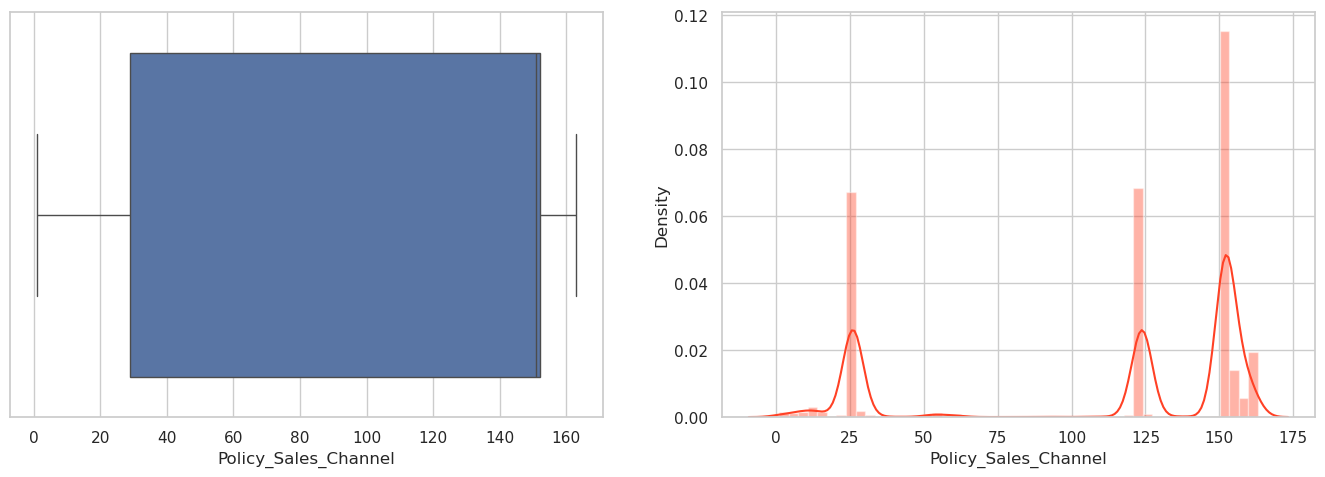

In [34]:
plot_num('Policy_Sales_Channel')

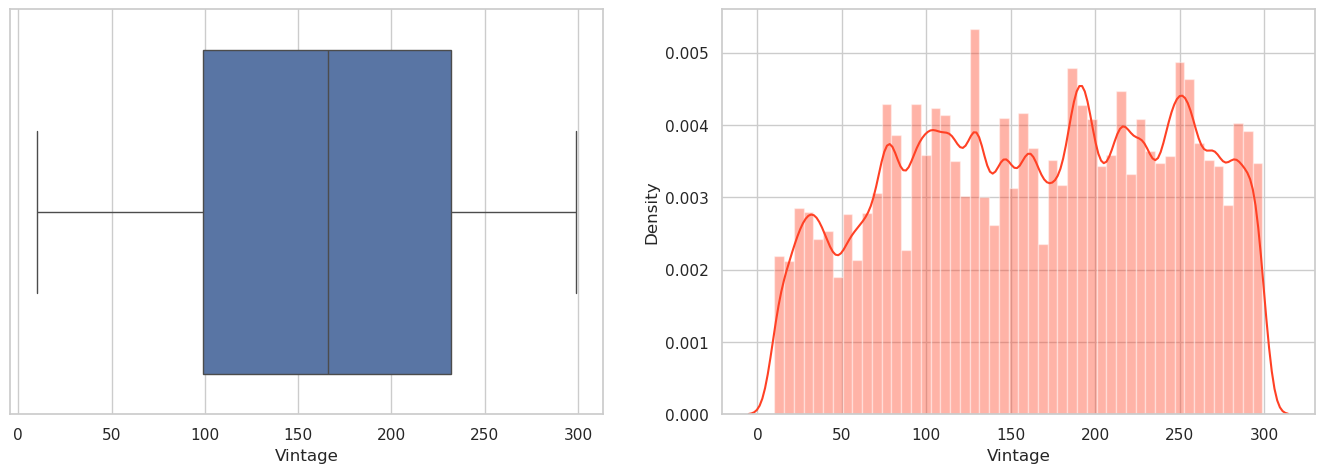

In [35]:
plot_num('Vintage')

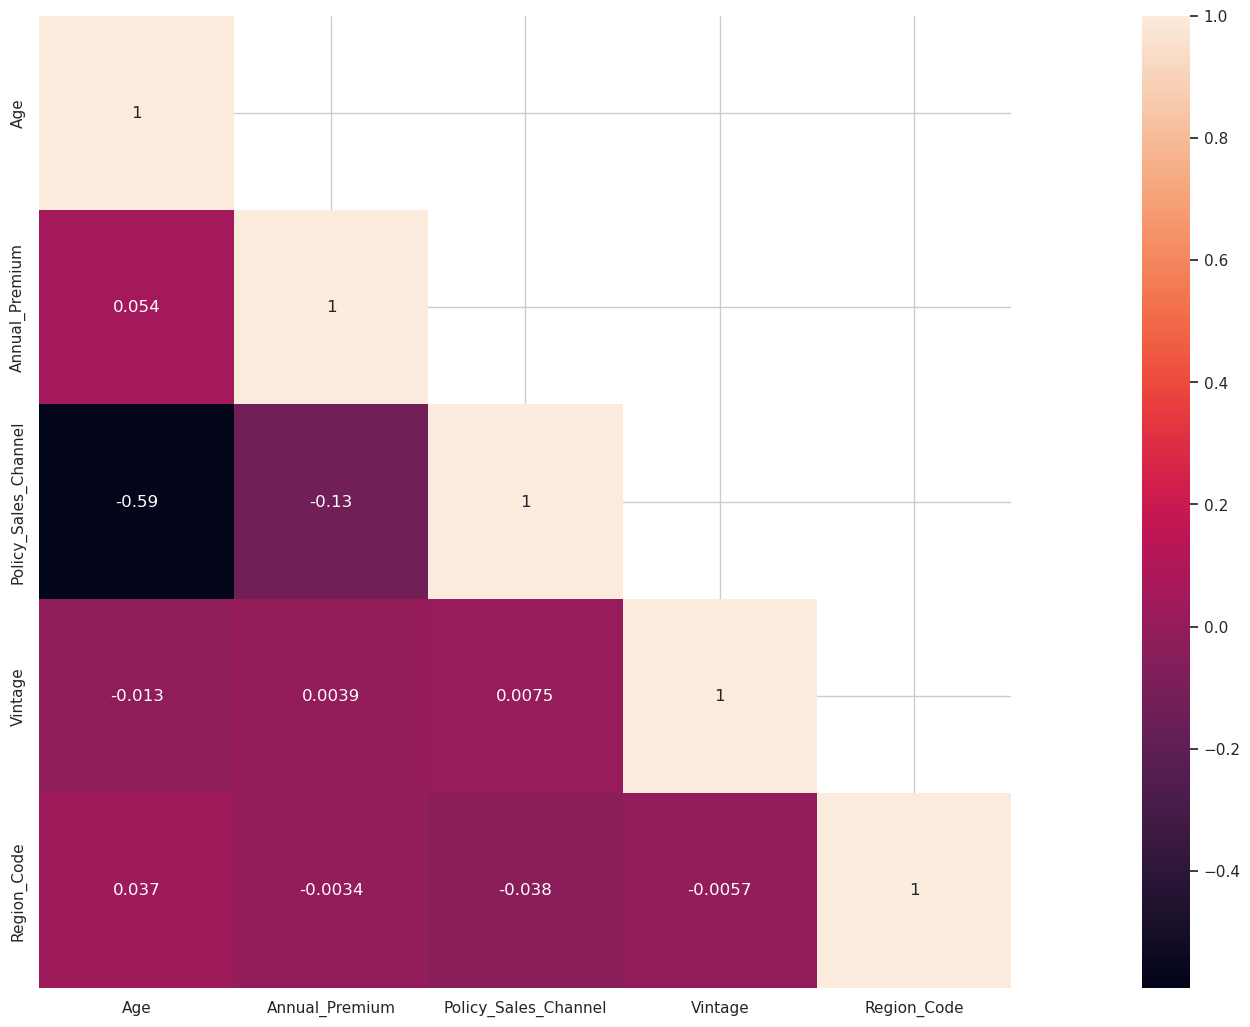

In [36]:
# Matriz de corelaciones
cor_mat = df[['Age', 'Annual_Premium','Policy_Sales_Channel', 'Vintage', 'Region_Code']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)
plt.show()

Observamos que no existen correlaciones significativas entre los tres grupos de variables

## 3.3. Recodificación y transformación de los datos

In [37]:
# Recodificamos variables 
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1}).astype("int32")
df["Region_Code"] = df["Region_Code"].astype(int)
df["Vehicle_Age"] = df["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}).astype("int32")
df["Vehicle_Damage"] = df["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype("int32")
df["Annual_Premium"] = df["Annual_Premium"].astype(int)
df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].astype(int)

# 4. Ingeniería y Selección de Variables

## 4.1. Ingeniería de variables

In [38]:
# Transformamos variables
df["Previously_Insured_Annual_Premium"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Annual_Premium"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Age"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Age"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Damage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Damage"].astype(str)
)[0]

df["Previously_Insured_Vintage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vintage"].astype(str)
)[0]

In [39]:
df.to_csv("../data/processed/insurance_val.csv")

## 4.2. Ingeniería de variables

In [53]:
import lightgbm as lgb
# Seleccion por LightGBM
train_data = lgb.Dataset(df.drop("Response", axis=1), label=df["Response"])

params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "num_leaves": 64,
    "learning_rate": 0.05,
    "n_jobs": -1
}

lgbm_model = lgb.train(params, train_data, num_boost_round=500)
importances = lgbm_model.feature_importance()

[LightGBM] [Info] Number of positive: 122997, number of negative: 877003
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122997 -> initscore=-1.964350
[LightGBM] [Info] Start training from score -1.964350


In [55]:
drivers = df.drop("Response", axis=1).columns

TablaImportancia = pd.DataFrame({
    "Driver": drivers,
    "Importancia": importances
})

TablaImportancia["Importancia_pct"] = (
    TablaImportancia["Importancia"] / TablaImportancia["Importancia"].sum()
) * 100

ImportanciaVariables = (
    TablaImportancia
    .sort_values("Importancia_pct", ascending=False)
    .reset_index(drop=True)
)

ImportanciaVariables.head(20)

Driver  Importancia  Importancia_pct
0                             Vintage         5321        16.892063
1          Previously_Insured_Vintage         4926        15.638095
2                      Annual_Premium         4604        14.615873
3   Previously_Insured_Annual_Premium         4290        13.619048
4                                 Age         3899        12.377778
5                         Region_Code         3442        10.926984
6                Policy_Sales_Channel         2721         8.638095
7                         Vehicle_Age          550         1.746032
8                      Vehicle_Damage          535         1.698413
9                              Gender          440         1.396825
10                 Previously_Insured          326         1.034921
11     Previously_Insured_Vehicle_Age          274         0.869841
12  Previously_Insured_Vehicle_Damage          108         0.342857
13                    Driving_License           64         0.203175

In [51]:
# Regresion Logistica
import statsmodels.api as sm
logit_model = sm.Logit(df.Response, df.drop(['Response'], axis=1))
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.272784
         Iterations 11
                                  Results: Logit
Model:                    Logit                 Method:                MLE        
Dependent Variable:       Response              Pseudo R-squared:      0.268      
Date:                     2025-11-15 19:21      AIC:                   545596.4842
No. Observations:         1000000               BIC:                   545761.9013
Df Model:                 13                    Log-Likelihood:        -2.7278e+05
Df Residuals:             999986                LL-Null:               -3.7285e+05
Converged:                1.0000                LLR p-value:           0.0000     
No. Iterations:           11.0000               Scale:                 1.0000     
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------

<Axes: >

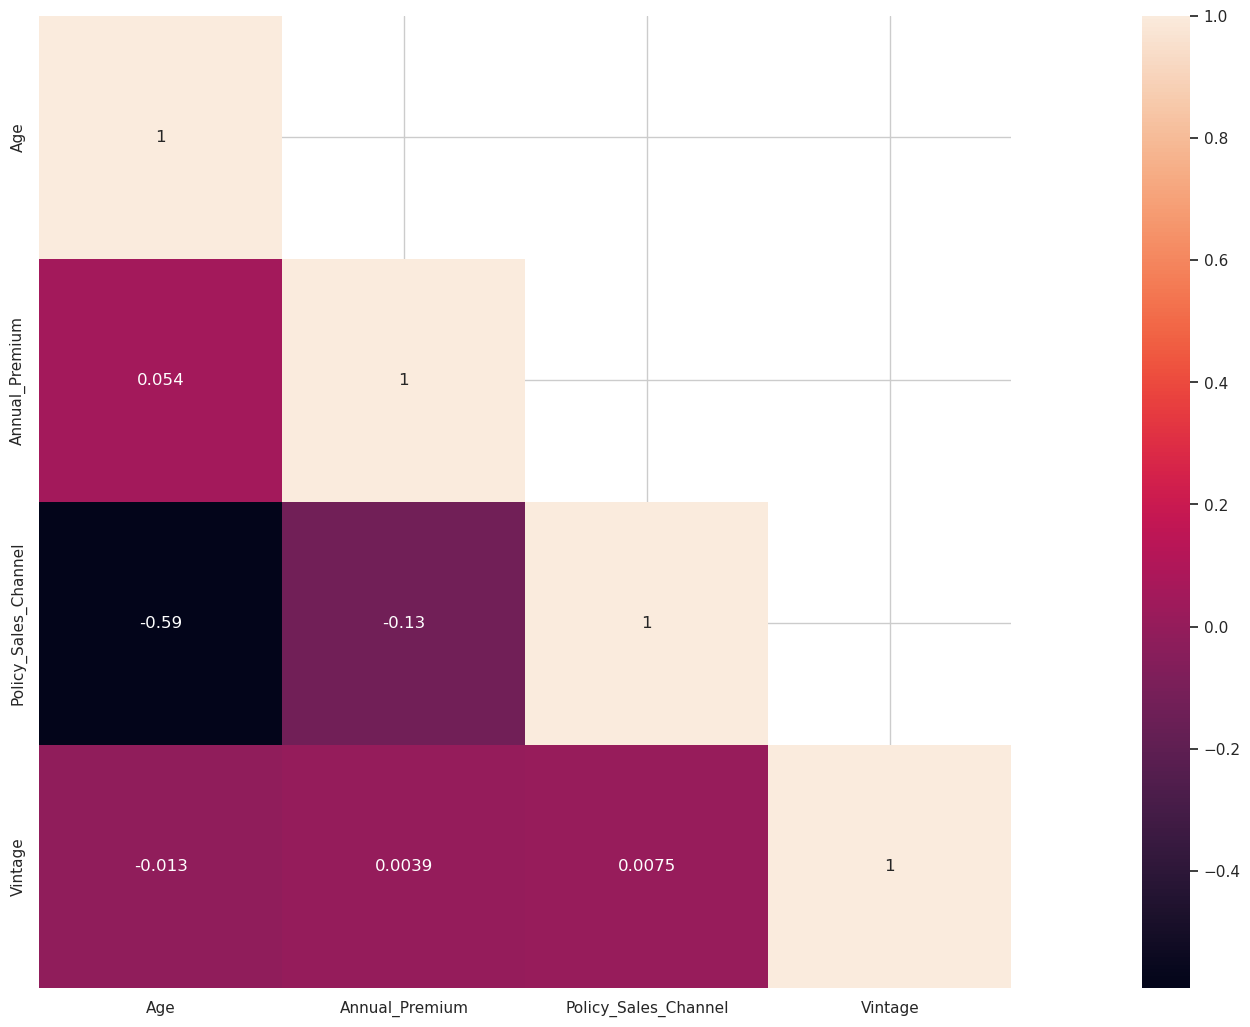

In [91]:
## Matriz de corelaciones numéricas
cor_mat = df[["Age","Annual_Premium","Policy_Sales_Channel","Vintage"]].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [94]:
# Análisis VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[["Gender","Age","Driving_License","Region_Code","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Age","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]]
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                             variable        VIF
0                              Gender   1.904985
1                                 Age  20.315204
2                     Driving_License  94.090978
3                         Region_Code   5.106720
4                  Previously_Insured   7.180708
5                         Vehicle_Age  15.998816
6                      Vehicle_Damage  12.589232
7                      Annual_Premium   5.840164
8                Policy_Sales_Channel   8.381773
9                             Vintage   5.206839
10  Previously_Insured_Annual_Premium   2.487269
11     Previously_Insured_Vehicle_Age  25.164787
12  Previously_Insured_Vehicle_Damage   4.174908
13         Previously_Insured_Vintage   3.544404


In [95]:
# Se elimina Driving_License y Previously_Insured_Vehicle_Age por VIF, baja significacia y baja importancia
X = df[["Gender","Age","Region_Code","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]]
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                             variable        VIF
0                              Gender   1.866664
1                                 Age  17.010180
2                         Region_Code   4.848546
3                  Previously_Insured   5.402747
4                         Vehicle_Age   6.257259
5                      Vehicle_Damage   8.546318
6                      Annual_Premium   5.488373
7                Policy_Sales_Channel   6.167121
8                             Vintage   4.895421
9   Previously_Insured_Annual_Premium   2.483218
10  Previously_Insured_Vehicle_Damage   3.260976
11         Previously_Insured_Vintage   3.406689


In [96]:
# Regresion Logistica sin Driving_License y Previously_Insured_Vehicle_Age
logit_model=sm.Logit(df.Response,df[["Gender","Age","Region_Code","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.275037
         Iterations 11
                                  Results: Logit
Model:                    Logit                 Method:                MLE        
Dependent Variable:       Response              Pseudo R-squared:      0.262      
Date:                     2025-11-15 21:05      AIC:                   550097.5582
No. Observations:         1000000               BIC:                   550239.3443
Df Model:                 11                    Log-Likelihood:        -2.7504e+05
Df Residuals:             999988                LL-Null:               -3.7285e+05
Converged:                1.0000                LLR p-value:           0.0000     
No. Iterations:           11.0000               Scale:                 1.0000     
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------

In [97]:
# Regresion Logistica sin Region_Code por no se significativo
logit_model=sm.Logit(df.Response,df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.275037
         Iterations 11
                                  Results: Logit
Model:                    Logit                 Method:                MLE        
Dependent Variable:       Response              Pseudo R-squared:      0.262      
Date:                     2025-11-15 21:06      AIC:                   550095.7108
No. Observations:         1000000               BIC:                   550225.6814
Df Model:                 10                    Log-Likelihood:        -2.7504e+05
Df Residuals:             999989                LL-Null:               -3.7285e+05
Converged:                1.0000                LLR p-value:           0.0000     
No. Iterations:           11.0000               Scale:                 1.0000     
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------

In [100]:
# Se elimina Region_Code por no se significativo
X = df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]]
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                             variable        VIF
0                              Gender   1.862830
1                                 Age  16.730067
2                  Previously_Insured   5.280602
3                         Vehicle_Age   6.257258
4                      Vehicle_Damage   8.246103
5                      Annual_Premium   5.464405
6                Policy_Sales_Channel   6.056108
7                             Vintage   4.877536
8   Previously_Insured_Annual_Premium   2.482847
9   Previously_Insured_Vehicle_Damage   3.201812
10         Previously_Insured_Vintage   3.396588


# 5. Modelamiento de Datos o Creación del Algoritmo de ML

## 5.1. Partición Muestral

In [176]:
data = df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage", "Response"]].sample(frac=0.9, random_state=1000)
data_unseen = df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage", "Response"]].drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (900000, 12)
Unseen Data For Predictions: (100000, 12)


In [181]:
# Creación de los datos de train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Response'],axis=1),
                                                   data.Response,
                                                   test_size=0.333,
                                                   random_state=12345) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(600300, 11) (600300,)
(299700, 11) (299700,)


In [182]:
X_train.head()

Gender  Age  Previously_Insured  Vehicle_Age  Vehicle_Damage  \
389951       0   80                   0            1               1   
377088       1   59                   1            1               0   
126011       0   41                   1            1               0   
3875         0   65                   0            1               1   
754242       0   47                   1            1               0   

        Annual_Premium  Policy_Sales_Channel  Vintage  \
389951           38341                   124      245   
377088            2630                    15      214   
126011           47383                   122      298   
3875             51743                    26      160   
754242           36998                   124       48   

        Previously_Insured_Annual_Premium  Previously_Insured_Vehicle_Damage  \
389951                              20754                                  0   
377088                                  4                                  1   
126011                               5621                                  1   
3875                                 4334                                  0   
754242                              25654                                  1   

        Previously_Insured_Vintage  
389951                         146  
377088                         302  
126011                         249  
3875                            96  
754242                          49

## 5.2. Algoritmos de Machine Learning

### Regresión Logística Binaria

In [183]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [184]:
lr.fit(X_train,y_train) # Entrenamiento!

LogisticRegression()

In [185]:
y_pred_train=lr.predict(X_train) # Prediccion sobre train
y_pred_test = lr.predict(X_test) # Prediccion sobre test

In [186]:
## Metricas de validación
def calc_metrics(y_train, y_pred_train, y_test, y_pred_test, show_train_report=False):
    # === MATRIZ DE CONFUSIÓN TRAIN ===
    print("=== Matriz de Confusión (Train) ===")
    cm_train = confusion_matrix(y_train, y_pred_train)
    print(cm_train)

    # === MATRIZ DE CONFUSIÓN TEST ===
    print("\n=== Matriz de Confusión (Test) ===")
    cm_test = confusion_matrix(y_test, y_pred_test)
    print(cm_test)

    # === CLASSIFICATION REPORT ===
    print("\n=== Classification Report (Test) ===")
    print(classification_report(y_test, y_pred_test))

    if show_train_report:
        print("\n=== Classification Report (Train) ===")
        print(classification_report(y_train, y_pred_train))

In [187]:
calc_metrics(y_train, y_pred_train, y_test, y_pred_test)

=== Matriz de Confusión (Train) ===
[[526558      0]
 [ 73742      0]]

=== Matriz de Confusión (Test) ===
[[262754      0]
 [ 36946      0]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    262754
           1       0.00      0.00      0.00     36946

    accuracy                           0.88    299700
   macro avg       0.44      0.50      0.47    299700
weighted avg       0.77      0.88      0.82    299700



In [188]:
ind = pd.DataFrame(columns = ['Modelo', 'F1Score'])

f1score=f1_score(y_test,y_pred_test)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['LogReg'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo  F1Score
0  LogReg      0.0

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  prob_avg  cnt_cust  cnt_resp  cnt_non_resp  \
0       1     0.239     0.435     0.270   29970.0    6033.0       23937.0   
1       2     0.196     0.239     0.218   29970.0    6048.0       23922.0   
2       3     0.127     0.196     0.162   29970.0    5263.0       24707.0   
3       4     0.110     0.127     0.117   29970.0    3749.0       26221.0   
4       5     0.101     0.110     0.105   29970.0    3159.0       26811.0   
5       6     0.094     0.101     0.097   29970.0    2896.0       27074.0   
6       7     0.087     0.094     0.090   29970.0    2635.0       27335.0   
7       8     0.080     0.087     0.084   29970.0    2516.0       27454.0   
8       9     0.072     0.080     0.077   29970.0    2301.0       27669.0   
9      10     0.033     0.072     0.066   29970.0    2346.0       27624.0   

   cnt_resp_rndm  cnt_resp_wiz  resp_rate  cum_cust  cum_resp  cum_resp_wiz  \
0         3694.6         29970     20.130   29970.0    6033.0         29970   
1         3694.6          6976     20.180   59940.0   12081.0         36946   
2         3694.6             0     17.561   89910.0   17344.0         36946   
3         3694.6             0     12.509  119880.0   21093.0         36946   
4         3694.6             0     10.541  149850.0   24252.0         36946   
5         3694.6             0      9.663  179820.0   27148.0         36946   
6         3694.6             0      8.792  209790.0   29783.0         36946   
7         3694.6             0      8.395  239760.0   32299.0         36946   
8         3694.6             0      7.678  269730.0   34600.0         36946   
9         3694.6             0      7.828  299700.0   36946.0         36946   

   cum_non_resp  cum_cust_pct  cum_resp_pct  cum_resp_pct_wiz  \
0       23937.0          10.0        16.329            81.118   
1       47859.0          20.0        32.699           100.000   
2       72566.0          30.0        46.944           100.000   
3       98787.0          40.0        57.091           100.000   
4      125598.0          50.0        65.642           100.000   
5      152672.0          60.0        73.480           100.000   
6      180007.0          70.0        80.612           100.000   
7      207461.0          80.0        87.422           100.000   
8      235130.0          90.0        93.650           100.000   
9      262754.0         100.0       100.000           100.000   

   cum_non_resp_pct      KS   lift  
0             9.110   7.219  1.633  
1            18.214  14.485  1.635  
2            27.617  19.327  1.565  
3            37.597  19.494  1.427  
4            47.801  17.841  1.313  
5            58.105  15.375  1.225  
6            68.508  12.104  1.152  
7            78.956   8.466  1.093  
8            89.487   4.163  1.041  
9           100.000   0.000  1.000

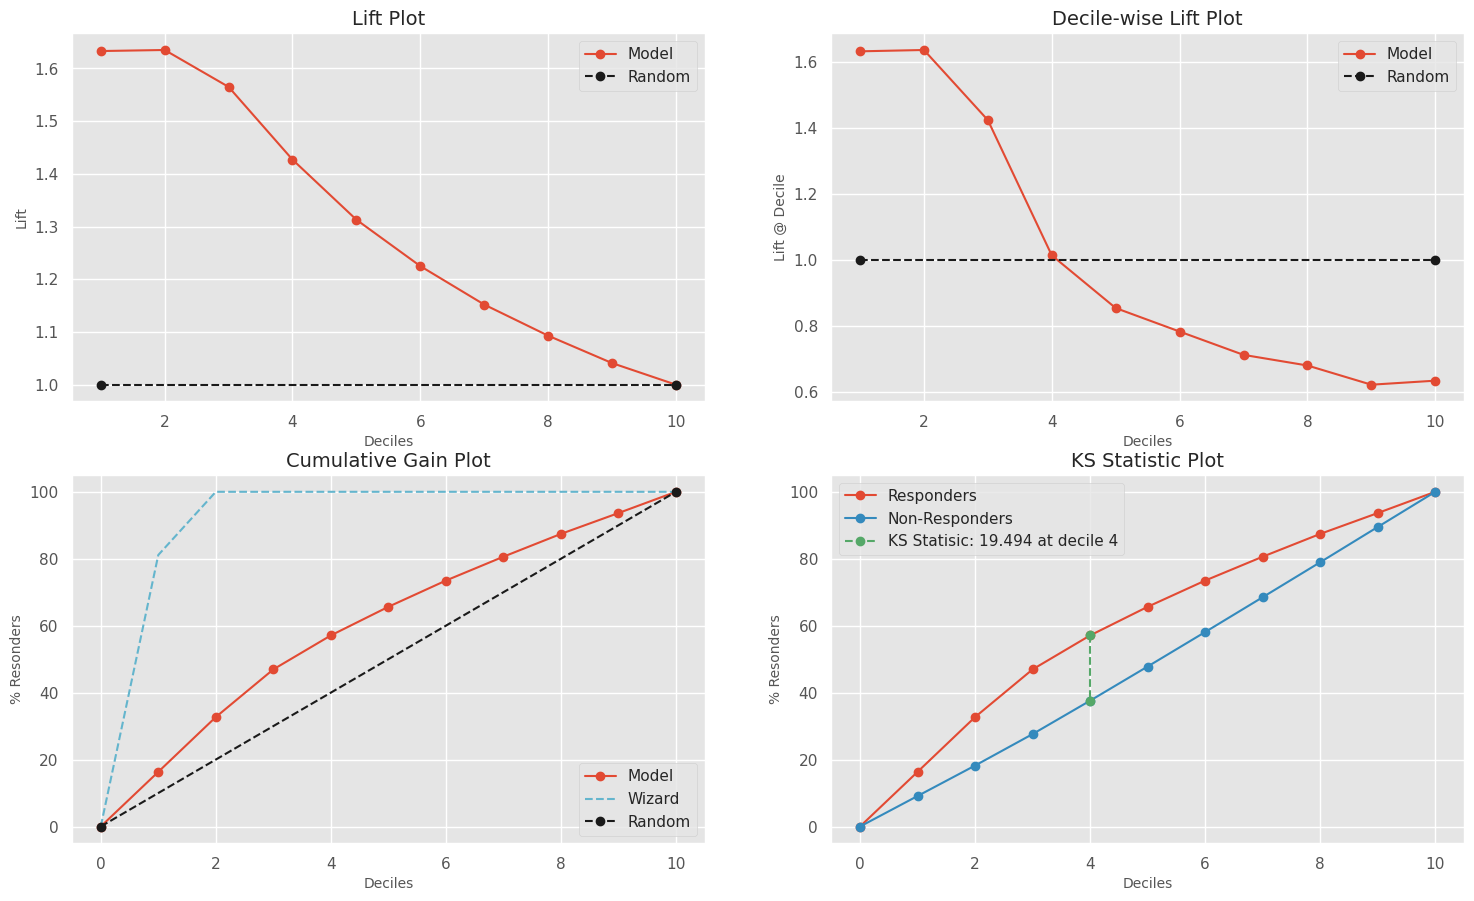

In [189]:
y_prob = lr.predict_proba(X_test)
kds.metrics.report(y_test, y_prob[:,1],plot_style='ggplot')

### Xgboost

In [191]:
import xgboost as xgb
xgb_mod=xgb.XGBClassifier(max_depth=2, n_estimators=50, objective='binary:logistic', seed=0, silent=True, subsample=.8)
xgb_mod.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [192]:
# Predecir con el algoritmo entrenado para validar
y_pred_train=xgb_mod.predict(X_train) # Prediccion sobre train
y_pred_test= xgb_mod.predict(X_test) # Prediccion sobre test

In [193]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

=== Matriz de Confusión (Train) ===
[[526369    189]
 [ 73435    307]]

=== Matriz de Confusión (Test) ===
[[262682     72]
 [ 36796    150]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    262754
           1       0.68      0.00      0.01     36946

    accuracy                           0.88    299700
   macro avg       0.78      0.50      0.47    299700
weighted avg       0.85      0.88      0.82    299700



In [194]:
f1score=f1_score(y_test,y_pred_test)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['XGBoost'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo   F1Score
0   LogReg  0.000000
1  XGBoost  0.008071

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  prob_avg  cnt_cust  cnt_resp  cnt_non_resp  \
0       1       0.0       1.0     0.007   29970.0    3759.0       26211.0   
1       2       0.0       0.0     0.000   29970.0    3762.0       26208.0   
2       3       0.0       0.0     0.000   29970.0    3644.0       26326.0   
3       4       0.0       0.0     0.000   29970.0    3730.0       26240.0   
4       5       0.0       0.0     0.000   29970.0    3545.0       26425.0   
5       6       0.0       0.0     0.000   29970.0    3692.0       26278.0   
6       7       0.0       0.0     0.000   29970.0    3670.0       26300.0   
7       8       0.0       0.0     0.000   29970.0    3664.0       26306.0   
8       9       0.0       0.0     0.000   29970.0    3730.0       26240.0   
9      10       0.0       0.0     0.000   29970.0    3750.0       26220.0   

   cnt_resp_rndm  cnt_resp_wiz  resp_rate  cum_cust  cum_resp  cum_resp_wiz  \
0         3694.6         29970     12.543   29970.0    3759.0         29970   
1         3694.6          6976     12.553   59940.0    7521.0         36946   
2         3694.6             0     12.159   89910.0   11165.0         36946   
3         3694.6             0     12.446  119880.0   14895.0         36946   
4         3694.6             0     11.828  149850.0   18440.0         36946   
5         3694.6             0     12.319  179820.0   22132.0         36946   
6         3694.6             0     12.246  209790.0   25802.0         36946   
7         3694.6             0     12.226  239760.0   29466.0         36946   
8         3694.6             0     12.446  269730.0   33196.0         36946   
9         3694.6             0     12.513  299700.0   36946.0         36946   

   cum_non_resp  cum_cust_pct  cum_resp_pct  cum_resp_pct_wiz  \
0       26211.0          10.0        10.174            81.118   
1       52419.0          20.0        20.357           100.000   
2       78745.0          30.0        30.220           100.000   
3      104985.0          40.0        40.316           100.000   
4      131410.0          50.0        49.911           100.000   
5      157688.0          60.0        59.904           100.000   
6      183988.0          70.0        69.837           100.000   
7      210294.0          80.0        79.754           100.000   
8      236534.0          90.0        89.850           100.000   
9      262754.0         100.0       100.000           100.000   

   cum_non_resp_pct     KS   lift  
0             9.975  0.199  1.017  
1            19.950  0.407  1.018  
2            29.969  0.251  1.007  
3            39.956  0.360  1.008  
4            50.013 -0.102  0.998  
5            60.014 -0.110  0.998  
6            70.023 -0.186  0.998  
7            80.035 -0.281  0.997  
8            90.021 -0.171  0.998  
9           100.000  0.000  1.000

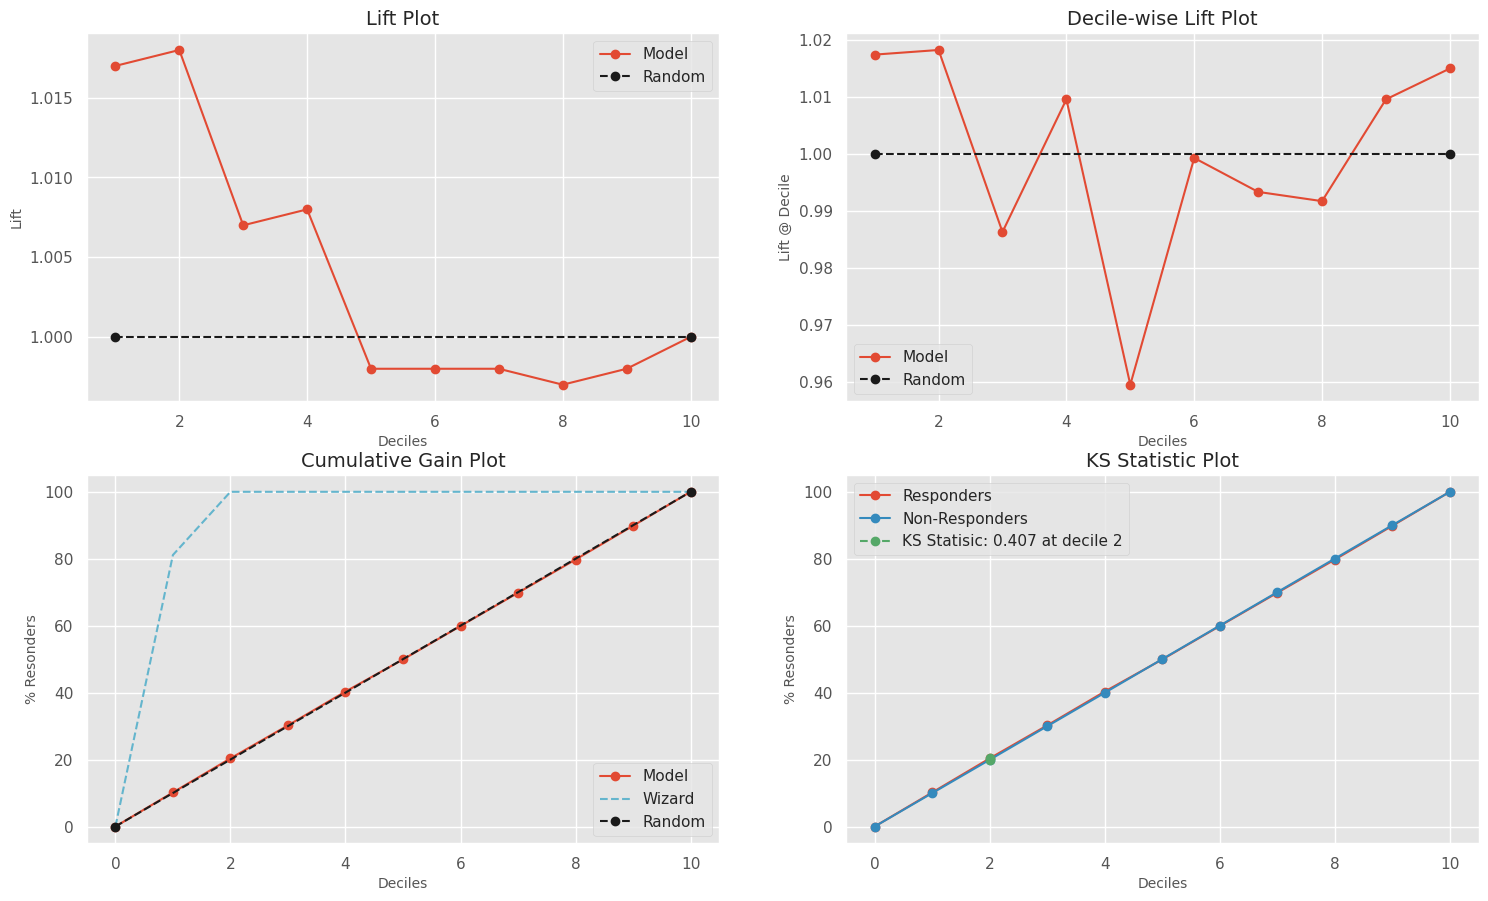

In [195]:
kds.metrics.report(y_test, y_pred_test,plot_style='ggplot')

### Grid Search de Parámetros

In [196]:
# Definimos la funcion de GridSearch
from sklearn.model_selection import GridSearchCV         # Busqueda exhaustiva de la mejor combinacion
from sklearn.model_selection import RandomizedSearchCV   # Busqueda aleatoria de la mejor combinacion
from scipy.stats import randint as sp_randint

In [197]:
# Configuramos el subset de parametros a trabajar
cv_params = {'max_depth': [2,3,4],
            'subsample':[0.7,0.8,0.9],
             'n_estimators':[50,100,200]}

In [198]:
# Definimos un clasificador inicial, generalmente sin muchos parametros
xgboost_t=xgb.XGBClassifier().fit(X_train, y_train)

In [199]:
# Con el clasificador inicial, tratamos de buscar los mejores parametros
optimized_GBM = RandomizedSearchCV(xgboost_t, cv_params, scoring = 'accuracy', cv = 5) 

In [200]:
# Buscamos los parametros de acuerdo a nuestro criterio
opGBM=optimized_GBM.fit(X_train, y_train)

In [201]:
# De acuerdo a la busqueda , nos quedamos con los mejores parametros 
print (optimized_GBM.best_params_)

{'subsample': 0.9, 'n_estimators': 200, 'max_depth': 4}


In [202]:
# Predecimos con el algoritmo entrenado sobre el test y evaluamos
y_pred_train=opGBM.predict(X_train)
y_pred_test=opGBM.predict(X_test)

In [203]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

=== Matriz de Confusión (Train) ===
[[521334   5224]
 [ 65824   7918]]

=== Matriz de Confusión (Test) ===
[[259970   2784]
 [ 33171   3775]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.89      0.99      0.94    262754
           1       0.58      0.10      0.17     36946

    accuracy                           0.88    299700
   macro avg       0.73      0.55      0.55    299700
weighted avg       0.85      0.88      0.84    299700



In [204]:
f1score=f1_score(y_test,y_pred_test)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['GridSearch'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo   F1Score
0      LogReg  0.000000
1     XGBoost  0.008071
2  GridSearch  0.173543

In [205]:
from sklearn.metrics import precision_recall_curve

y_prob_test = opGBM.predict_proba(X_test)[:, 1]

# Calcular curva precision-recall
prec, rec, thresholds = precision_recall_curve(y_test, y_prob_test)

# Evitar división por cero
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)

# Índice del mejor F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("Mejor threshold:", best_threshold)
print("F1 alcanzado:", best_f1)

Mejor threshold: 0.23989873
F1 alcanzado: 0.48452960676308826


In [206]:
y_pred_test_opt = (y_prob_test >= best_threshold).astype(int)
calc_metrics(y_train, y_pred_train, y_test, y_pred_test_opt)

=== Matriz de Confusión (Train) ===
[[521334   5224]
 [ 65824   7918]]

=== Matriz de Confusión (Test) ===
[[216459  46295]
 [ 10332  26614]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.95      0.82      0.88    262754
           1       0.37      0.72      0.48     36946

    accuracy                           0.81    299700
   macro avg       0.66      0.77      0.68    299700
weighted avg       0.88      0.81      0.84    299700



In [207]:
f1score=f1_score(y_test,y_pred_test_opt)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['GridSearchUmbral'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo   F1Score
0            LogReg  0.000000
1           XGBoost  0.008071
2        GridSearch  0.173543
3  GridSearchUmbral  0.484530

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  prob_avg  cnt_cust  cnt_resp  cnt_non_resp  \
0       1     0.367     0.842     0.452   29970.0   13729.0       16241.0   
1       2     0.275     0.367     0.319   29970.0    9501.0       20469.0   
2       3     0.193     0.275     0.234   29970.0    6985.0       22985.0   
3       4     0.108     0.193     0.150   29970.0    4543.0       25427.0   
4       5     0.026     0.108     0.065   29970.0    1903.0       28067.0   
5       6     0.001     0.026     0.008   29970.0     253.0       29717.0   
6       7     0.000     0.001     0.000   29970.0      19.0       29951.0   
7       8     0.000     0.000     0.000   29970.0       5.0       29965.0   
8       9     0.000     0.000     0.000   29970.0       7.0       29963.0   
9      10     0.000     0.000     0.000   29970.0       1.0       29969.0   

   cnt_resp_rndm  cnt_resp_wiz  resp_rate  cum_cust  cum_resp  cum_resp_wiz  \
0         3694.6         29970     45.809   29970.0   13729.0         29970   
1         3694.6          6976     31.702   59940.0   23230.0         36946   
2         3694.6             0     23.307   89910.0   30215.0         36946   
3         3694.6             0     15.158  119880.0   34758.0         36946   
4         3694.6             0      6.350  149850.0   36661.0         36946   
5         3694.6             0      0.844  179820.0   36914.0         36946   
6         3694.6             0      0.063  209790.0   36933.0         36946   
7         3694.6             0      0.017  239760.0   36938.0         36946   
8         3694.6             0      0.023  269730.0   36945.0         36946   
9         3694.6             0      0.003  299700.0   36946.0         36946   

   cum_non_resp  cum_cust_pct  cum_resp_pct  cum_resp_pct_wiz  \
0       16241.0          10.0        37.160            81.118   
1       36710.0          20.0        62.876           100.000   
2       59695.0          30.0        81.782           100.000   
3       85122.0          40.0        94.078           100.000   
4      113189.0          50.0        99.229           100.000   
5      142906.0          60.0        99.913           100.000   
6      172857.0          70.0        99.965           100.000   
7      202822.0          80.0        99.978           100.000   
8      232785.0          90.0        99.997           100.000   
9      262754.0         100.0       100.000           100.000   

   cum_non_resp_pct      KS   lift  
0             6.181  30.979  3.716  
1            13.971  48.905  3.144  
2            22.719  59.063  2.726  
3            32.396  61.682  2.352  
4            43.078  56.151  1.985  
5            54.388  45.525  1.665  
6            65.787  34.178  1.428  
7            77.191  22.787  1.250  
8            88.594  11.403  1.111  
9           100.000   0.000  1.000

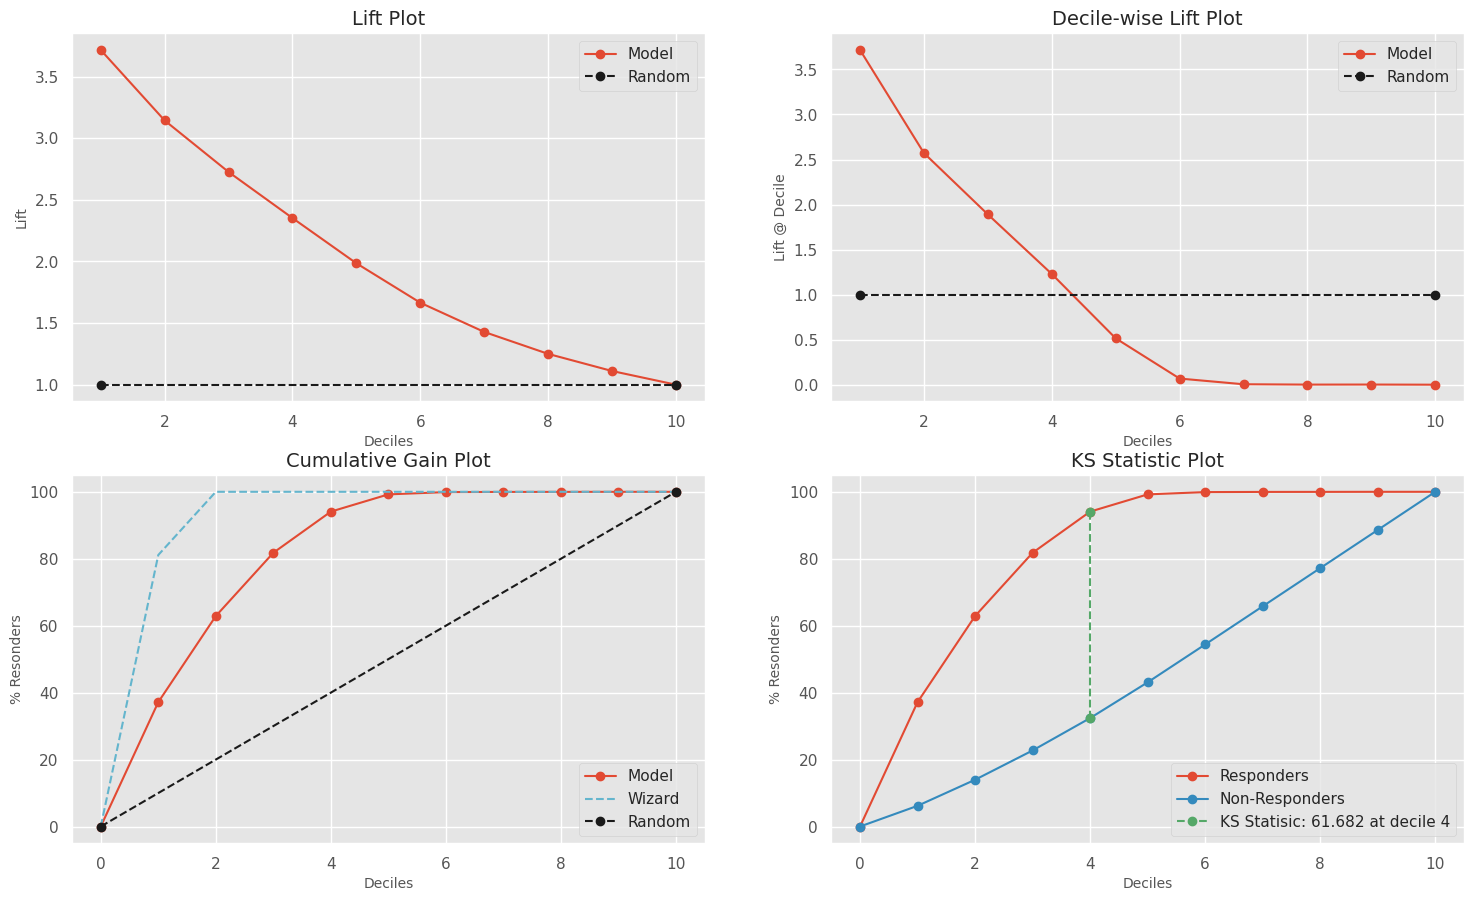

In [208]:
y_prob = opGBM.predict_proba(X_test)
kds.metrics.report(y_test, y_prob[:,1],plot_style='ggplot')

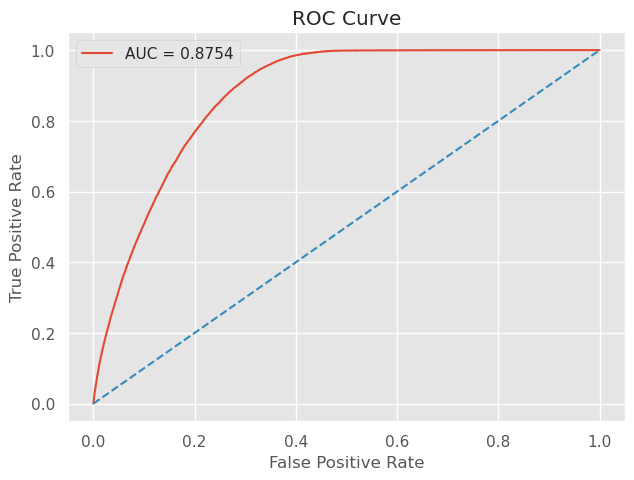

In [209]:
# Probabilidades predichas
y_prob_test = opGBM.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 6. Evaluación de Modelos


In [210]:
# Guardamos el mejor modelo entrenado para usarlo en la implementación
import pickle
filename = 'bestmodel.pkl'
pickle.dump(opGBM, open(filename, 'wb'))

# 7. Scoring del Modelo


In [ ]:
# Todo lo realizado en el dataset de entrenamiento del modelo lo debemos replicar en el dataset de scoring

In [211]:
data_unseen.shape

(100000, 12)

In [212]:
data_unseen.head()

Gender  Age  Previously_Insured  Vehicle_Age  Vehicle_Damage  \
0       1   22                   1            0               0   
1       0   35                   1            1               0   
2       1   25                   1            0               0   
3       0   58                   1            1               0   
4       1   44                   0            1               1   

   Annual_Premium  Policy_Sales_Channel  Vintage  \
0           44905                   152      191   
1            2630                   152      201   
2           33442                   152      142   
3           44743                   124       91   
4           25103                   122      162   

   Previously_Insured_Annual_Premium  Previously_Insured_Vehicle_Damage  \
0                                  3                                  1   
1                                  4                                  1   
2                                  9                                  1   
3                                 17                                  1   
4                                 18                                  0   

   Previously_Insured_Vintage  Response  
0                           3         0  
1                           9         0  
2                          11         0  
3                          20         0  
4                          21         0

In [213]:
# Una vez que tenemos todas las variables podemos scorear o puntuar los registros

# Leemos el modelo entrenado!
import pickle
filename = 'bestmodel.pkl'
mod_seg = pickle.load(open(filename, 'rb'))

In [214]:
# Predecimos sobre el set de datos de implementacion con el modelo entrenado
prob_final = mod_seg.predict_proba(data_unseen.drop(['Response'], axis=1))[:, 1]
pred_final = (prob_final >= best_threshold).astype(int)

In [215]:
pred_final.size

100000

In [216]:
# Construir DataFrame final
df_submit = pd.DataFrame({
    'Response': data_unseen['Response'],
    'Prob': prob_final,
    'Predicted': pred_final
})
# Exportamos la solucion
df_submit.to_csv('valida_scoring.csv', index=False)